In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 15.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.5.4.60
    Uninstalling opencv-contrib-python-4.5.4.60:
      Successfully uninstalled opencv-contrib-python-4.5.4.60


In [3]:
import torch
IMAGE_PATH="/kaggle/input/vale-semantic-terrain-segmentation/raw_images/raw_images/"
MASK_PATH="/kaggle/input/vale-semantic-terrain-segmentation/mask_rgb_filled/mask_rgb_filled/"
DEVICE=torch.device('cuda')

In [4]:
import sys
import cv2
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import csv


In [5]:
#Make changes
def split_image_into_sixteen(image, rows=4, cols=4):
    if(image.ndim==3):
        height, width, _ = image.shape
    elif(image.ndim==2):
        height,width=image.shape
    # Calculate the size of each block
    block_height = height // rows
    block_width = width // cols

    # Initialize an empty list to store the divided image parts
    divided_image_parts = []
    # Loop through the image grid and append each part to the divided_parts list
    for i in range(rows):
        for j in range(cols):
            # Compute the coordinates of the current block
            y_start = i * block_height
            y_end = (i + 1) * block_height
            x_start = j * block_width
            x_end = (j + 1) * block_width
            if (image.ndim==3):
                divided_image_parts.append(image[y_start:y_end, x_start:x_end,:])
            elif (image.ndim==2):
                divided_image_parts.append(image[y_start:y_end, x_start:x_end])


    return divided_image_parts


def reconstruct_image(divided_image_parts,rows=4, cols=4):
    image_rows = []
    mask_rows=[]

    for i in range(rows):
        image_row = np.hstack(divided_image_parts[i * cols : (i + 1) * cols])
        image_rows.append(image_row)

    reconstructed_image = np.vstack(image_rows)
    
    return reconstructed_image

In [6]:
def one_hot_decoding(one_hot_encoded):
    # Prepare the blank image with the same dimensions as the input
    decoded_image = np.zeros((one_hot_encoded.shape[0], one_hot_encoded.shape[1], 3), dtype=np.uint8)

    # Yellow
    YELLOW = np.array([255, 255, 0])
    yellow_pixels = one_hot_encoded[:, :, 0] == 1
    decoded_image[yellow_pixels] = YELLOW

    # Red
    RED = np.array([255, 0, 0])
    red_pixels = one_hot_encoded[:, :, 1] == 1
    decoded_image[red_pixels] = RED

    # Green
    GREEN = np.array([0, 255, 0])
    green_pixels = one_hot_encoded[:, :, 2] == 1
    decoded_image[green_pixels] = GREEN

    # Orange
    ORANGE = np.array([255, 128, 0])
    orange_pixels = one_hot_encoded[:, :, 3] == 1
    decoded_image[orange_pixels] = ORANGE

    return decoded_image

In [7]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
    
class AttentionLayer(nn.Module):
    def __init__(self, num_channels, reduced_channels):
        super(AttentionLayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(num_channels, reduced_channels, bias=False),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y)
        y = self.softmax(y).view(b, -1, 1, 1)
        return x * y
    
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=4, features=[64,128,256,512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.attentions_down = nn.ModuleList()  
        self.attentions_up = nn.ModuleList()
        self.attention1=AttentionLayer(features[-1],features[-1])
        self.attention2=AttentionLayer(features[-1]*2,features[-1]*2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            self.attentions_down.append(AttentionLayer(feature, feature))  
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            self.attentions_up.append(AttentionLayer(feature, feature))  

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, 3,1,1,bias=False)

    def forward(self, x):
        skip_connections = []
        
        #print("Down conv part ")
        for idx, (down, attention) in enumerate(zip(self.downs, self.attentions_down)):
            x = down(x)
            x = attention(x)
            skip_connections.append(x)
            x = self.pool(x)
            #print(f"idx= {idx} shape={x.shape}")
        #print("Dim after attention: ",x.shape)
        x = self.attention1(x)
        x = self.bottleneck(x)
        x = self.attention2(x)
        skip_connections = skip_connections[::-1]
        
        #print("Up conv part ")
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            #print(f"idx={idx} shape={x.shape}")

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            x = self.attentions_up[idx // 2](x)  
        return self.final_conv(x)

In [8]:
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [9]:
model = UNET(in_channels=3, out_channels=4).to(DEVICE)

In [10]:
%cp /kaggle/input/smallestunetfinal/best_checkpoint.pth .

In [11]:
load_checkpoint(torch.load("best_checkpoint.pth"), model)
print("Model loaded")

=> Loading checkpoint
Model loaded


In [12]:
def convert_to_one_hot(predicted):
    # Find the class with the highest probability along the channel dimension
    max_indices = torch.argmax(predicted, dim=1)

    # Convert the max_indices tensor to one-hot encoding
    one_hot_predicted = F.one_hot(max_indices, num_classes=predicted.size(1))
    return one_hot_predicted

In [13]:
def dice_score(predicted, target, eps=1e-7):
    assert predicted.size() == target.size(), "Input tensors must have the same shape"
    
    # Initialize an empty tensor to store the Dice scores for each class
    dice_scores = torch.zeros(predicted.size(1), device=predicted.device, dtype=predicted.dtype)

    # Iterate over each class and calculate the Dice score
    for class_idx in range(predicted.size(1)):
        pred_class = predicted[:, class_idx].contiguous().view(predicted.size(0), -1)
        target_class = target[:, class_idx].contiguous().view(target.size(0), -1)

        intersection = (pred_class * target_class).sum(dim=1)
        volumes = pred_class.sum(dim=1) + target_class.sum(dim=1)

        dice_scores[class_idx] = ((2 * intersection + eps) / (volumes + eps)).mean()

    return dice_scores

In [14]:
from torchvision import transforms

In [15]:
def infer_results(model,image):
    image_parts=split_image_into_sixteen(image)
    transform=transforms.ToTensor()
    
    reconstructed_part_list=[]
    squeezed_parts_list=[]
    for part in image_parts:
        partTensor=transform(part)
        #print("Tensor shape= ",partTensor.shape)
        part=torch.unsqueeze(partTensor,0)
        #print("unsqueeze = ", part.shape)
        part=part.to(DEVICE)

        
        with torch.no_grad():
            preds=model(part)
            
        one_hot=convert_to_one_hot(preds)
        #print("one hot= ",one_hot.shape)
        squeeze=torch.squeeze(one_hot,0)
        #print("Squeezed= ",squeeze.shape)
        squeeze=squeeze.to('cpu')
        squeezed_parts_list.append(squeeze)
        reconstructed=one_hot_decoding(squeeze)
        reconstructed_part_list.append(reconstructed)
    im=reconstruct_image(reconstructed_part_list)
    one_hot_encoded=reconstruct_image(squeezed_parts_list)
    #print("image shape= ",im.shape)
    return im,one_hot_encoded

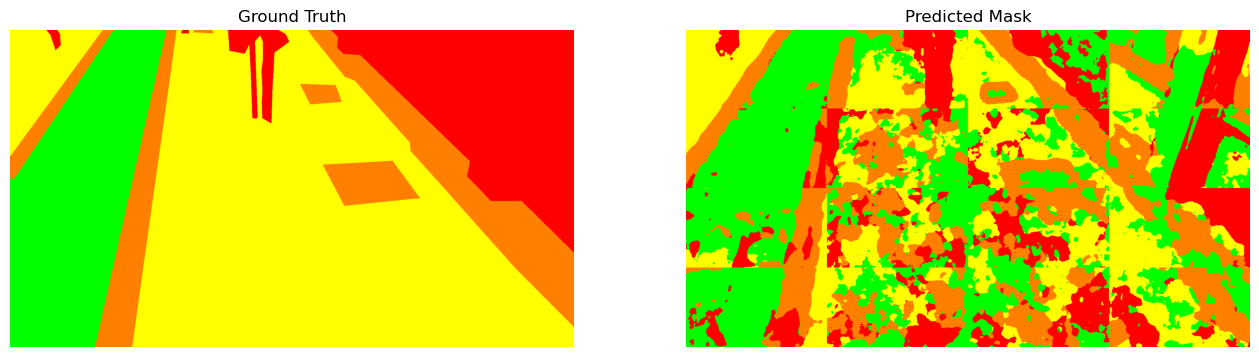

In [16]:
mask_path=MASK_PATH+"05077.png"
mask=cv2.imread(mask_path)
mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
image_path=IMAGE_PATH+"05077.png"
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
re_mask,one_hot_encoded=infer_results(model,image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.set_title("Ground Truth")
ax1.imshow(mask)
ax1.set_axis_off();        

ax2.set_title("Predicted Mask")
ax2.imshow(re_mask)
ax2.set_axis_off();
figure_filename = "comparison_figure.png"
f.savefig(figure_filename, bbox_inches='tight')